In [ ]:
import numpy as np
import numpy as np
from tensorflow import optimizers

from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.applications import VGG16, InceptionV3
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels with nearest pixel values
)

# Define ImageDataGenerator for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set batch size
batch_size = 32

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/train',                 # Directory containing training images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/test',            # Directory containing validation images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

Found 1447 images belonging to 3 classes.
Found 404 images belonging to 3 classes.


In [ ]:
# Load VGG16 model with pretrained weights
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Obtain outputs from each base model
vgg_output = vgg_base(input_layer)
inception_output = inception_base(input_layer)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Apply global average pooling to the outputs from the base models
vgg_output = GlobalAveragePooling2D()(vgg_output)
inception_output = GlobalAveragePooling2D()(inception_output)

In [ ]:
# Concatenate outputs of both models
merged_output = concatenate([vgg_output, inception_output])


In [ ]:
# Add dense layers for classification with dropout and regularization
x = Dense(512, activation='relu')(merged_output)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create model
ensemble_model = Model(inputs=input_layer, outputs=predictions)

In [ ]:
# Freeze layers in both models
for layer in vgg_base.layers:
    layer.trainable = False
for layer in inception_base.layers:
    layer.trainable = False


In [ ]:
ensemble_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_8[0][0]']             
                                                          8                                       
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_8[0][0]']             
                                                          4                                       
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_lr=1e-6)

callbacks = [checkpoint, lr_scheduler]

# Define learning rate scheduler
def lr_schedule(epoch):
    """
    Learning rate scheduler.
    """
    initial_lr = 0.01
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * 0.1

# Training configuration
epochs = 15
initial_learning_rate = 0.01
steps_per_epoch = len(train_generator)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Start training
start_time = datetime.now()

history = ensemble_model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks)

# Calculate training duration
training_duration = datetime.now() - start_time
print("Training duration:", training_duration)


Epoch 1/15
46/46 [==============================] - ETA: 0s - loss: 0.7945 - accuracy: 0.7319
Epoch 1: val_loss improved from inf to 0.34476, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 544s 11s/step - loss: 0.7945 - accuracy: 0.7319 - val_loss: 0.3448 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 2/15
46/46 [==============================] - ETA: 0s - loss: 0.3788 - accuracy: 0.8569
Epoch 2: val_loss improved from 0.34476 to 0.34272, saving model to model_checkpoint.h5
46/46 [==============================] - 63s 1s/step - loss: 0.3788 - accuracy: 0.8569 - val_loss: 0.3427 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 3/15
46/46 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8507
Epoch 3: val_loss improved from 0.34272 to 0.33299, saving model to model_checkpoint.h5
46/46 [==============================] - 61s 1s/step - loss: 0.3833 - accuracy: 0.8507 - val_loss: 0.3330 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 4/15
46/46 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.8694
Epoch 4: val_loss did not improve from 0.33299
46/46 [==============================] - 61s 1s/step - loss: 0.3235

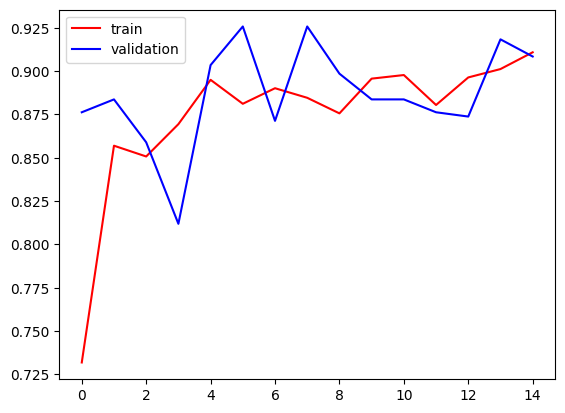

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

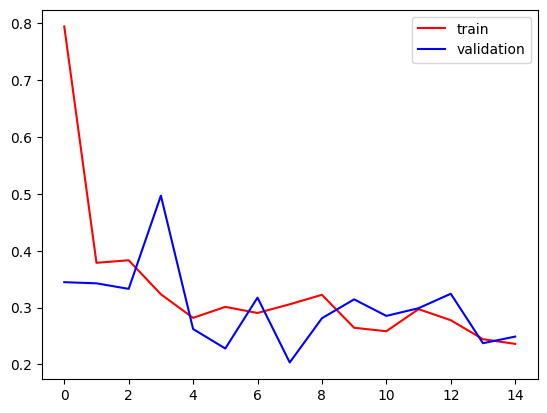

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
loss, accuracy = ensemble_model.evaluate(validation_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 10s 755ms/step - loss: 0.2490 - accuracy: 0.9084
Test Loss: 0.249042809009552
Test Accuracy: 0.9084158539772034


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = ensemble_model.evaluate(train_generator)

# Predict classes for training set
train_predictions = ensemble_model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the validation set
val_loss, val_accuracy = ensemble_model.evaluate(validation_generator)

# Predict classes for validation set
val_predictions = ensemble_model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Get true labels for validation set
val_true_classes = validation_generator.classes

# Generate classification report for validation set
val_report = classification_report(val_true_classes, val_predicted_classes, target_names=class_labels)

print("Validation Classification Report:")
print(val_report)


46/46 [==============================] - 53s 1s/step
Training Classification Report:
              precision    recall  f1-score   support

     COVID19       0.35      0.34      0.34       460
      NORMAL       0.36      0.39      0.37       504
   PNEUMONIA       0.34      0.32      0.33       483

    accuracy                           0.35      1447
   macro avg       0.35      0.35      0.35      1447
weighted avg       0.35      0.35      0.35      1447

13/13 [==============================] - 10s 768ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     COVID19       0.34      0.31      0.32       116
      NORMAL       0.37      0.44      0.40       160
   PNEUMONIA       0.30      0.25      0.27       128

    accuracy                           0.34       404
   macro avg       0.33      0.33      0.33       404
weighted avg       0.34      0.34      0.34       404

